In [7]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

## 1. Initial Data Inspection and Cleaning

- Check for Duplicates: Identify and remove duplicate rows based on unique song IDs.

- Handle Missing Values: Assess missing values in critical columns like popularity, album, or name. Impute or drop rows/columns as necessary.

- Identify Outliers: Use statistical methods (e.g., IQR) to detect outliers in numerical features like popularity, tempo, or loudness.

- Correct Erroneous Entries: Ensure values fall within expected ranges (e.g., danceability between 0 and 1). Rectify or remove invalid entries.

In [8]:
# Load the dataset to examine its contents
stones_data = pd.read_csv('rolling_stones_spotify.csv')

# Display the first few rows to understand the structure of the data
print("Initial Data Inspection:")
stones_data.head()

Initial Data Inspection:


,Unnamed: 0,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,0,Concert Intro Music - Live,Licked Live In NYC,2022-06-10,1,2IEkywLJ4ykbhi1yRQvmsT,spotify:track:2IEkywLJ4ykbhi1yRQvmsT,0.0824,0.463,0.993,0.996000,0.932,-12.913,0.1100,118.001,0.0302,33,48640
1,1,Street Fighting Man - Live,Licked Live In NYC,2022-06-10,2,6GVgVJBKkGJoRfarYRvGTU,spotify:track:6GVgVJBKkGJoRfarYRvGTU,0.4370,0.326,0.965,0.233000,0.961,-4.803,0.0759,131.455,0.3180,34,253173
2,2,Start Me Up - Live,Licked Live In NYC,2022-06-10,3,1Lu761pZ0dBTGpzxaQoZNW,spotify:track:1Lu761pZ0dBTGpzxaQoZNW,0.4160,0.386,0.969,0.400000,0.956,-4.936,0.1150,130.066,0.3130,34,263160
3,3,If You Can't Rock Me - Live,Licked Live In NYC,2022-06-10,4,1agTQzOTUnGNggyckEqiDH,spotify:track:1agTQzOTUnGNggyckEqiDH,0.5670,0.369,0.985,0.000107,0.895,-5.535,0.1930,132.994,0.1470,32,305880
4,4,Don’t Stop - Live,Licked Live In NYC,2022-06-10,5,7piGJR8YndQBQWVXv6KtQw,spotify:track:7piGJR8YndQBQWVXv6KtQw,0.4000,0.303,0.969,0.055900,0.966,-5.098,0.0930,130.533,0.2060,32,305106


In [9]:
#Removing irrelevant column
stones_data.drop(stones_data.columns[0], axis=1, inplace=True)

In [10]:
# Examine basic information about the data
print("\nInformation about Data:")
print(stones_data.info())


Information about Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1610 non-null   object 
 1   album             1610 non-null   object 
 2   release_date      1610 non-null   object 
 3   track_number      1610 non-null   int64  
 4   id                1610 non-null   object 
 5   uri               1610 non-null   object 
 6   acousticness      1610 non-null   float64
 7   danceability      1610 non-null   float64
 8   energy            1610 non-null   float64
 9   instrumentalness  1610 non-null   float64
 10  liveness          1610 non-null   float64
 11  loudness          1610 non-null   float64
 12  speechiness       1610 non-null   float64
 13  tempo             1610 non-null   float64
 14  valence           1610 non-null   float64
 15  popularity        1610 non-null   int64  
 16  duration_ms      

In [11]:
# Check for duplicates
duplicate_rows = stones_data[stones_data.duplicated()]
num_duplicates = stones_data.duplicated().sum()
print(f"Number of duplicate entries: {num_duplicates}")
duplicate_rows

Number of duplicate entries: 0


,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms


In [12]:
# Check for missing values
missing_values = stones_data.isnull().sum()
missing_values

name                0
album               0
release_date        0
track_number        0
id                  0
uri                 0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
duration_ms         0
dtype: int64

There are no missing values or duplicate entries in the dataset.

In [13]:
# Basic statistics to probe the dataset
basic_stats = stones_data.describe()
basic_stats

,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
count,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.00000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000
mean,8.613665,0.250475,0.468860,0.792352,0.164170,0.49173,-6.971615,0.069512,126.082033,0.582165,20.788199,257736.488199
std,6.560220,0.227397,0.141775,0.179886,0.276249,0.34910,2.994003,0.051631,29.233483,0.231253,12.426859,108333.474920
min,1.000000,0.000009,0.104000,0.141000,0.000000,0.02190,-24.408000,0.023200,46.525000,0.000000,0.000000,21000.000000
25%,4.000000,0.058350,0.362250,0.674000,0.000219,0.15300,-8.982500,0.036500,107.390750,0.404250,13.000000,190613.000000
50%,7.000000,0.183000,0.458000,0.848500,0.013750,0.37950,-6.523000,0.051200,124.404500,0.583000,20.000000,243093.000000
75%,11.000000,0.403750,0.578000,0.945000,0.179000,0.89375,-4.608750,0.086600,142.355750,0.778000,27.000000,295319.750000
max,47.000000,0.994000,0.887000,0.999000,0.996000,0.99800,-1.014000,0.624000,216.304000,0.974000,80.000000,981866.000000


Values for danceability, energy, instrumentalness, liveness, speechiness, and valence are all between 0 and 1, as expected

In [8]:
# Explore the unique values in each column
unique_counts = stones_data.nunique()
print(unique_counts)

name                 954
album                 90
release_date          57
track_number          47
id                  1610
uri                 1610
acousticness         933
danceability         518
energy               511
instrumentalness    1134
liveness             757
loudness            1329
speechiness          655
tempo               1424
valence              701
popularity            69
duration_ms         1320
dtype: int64


In [9]:
# creating new feature that is duration in seconds
stones_data['duration_seconds'] = stones_data['duration_ms'] / 1000

We will use boxplots to visualize outliers in columns that looks interesting to explore.

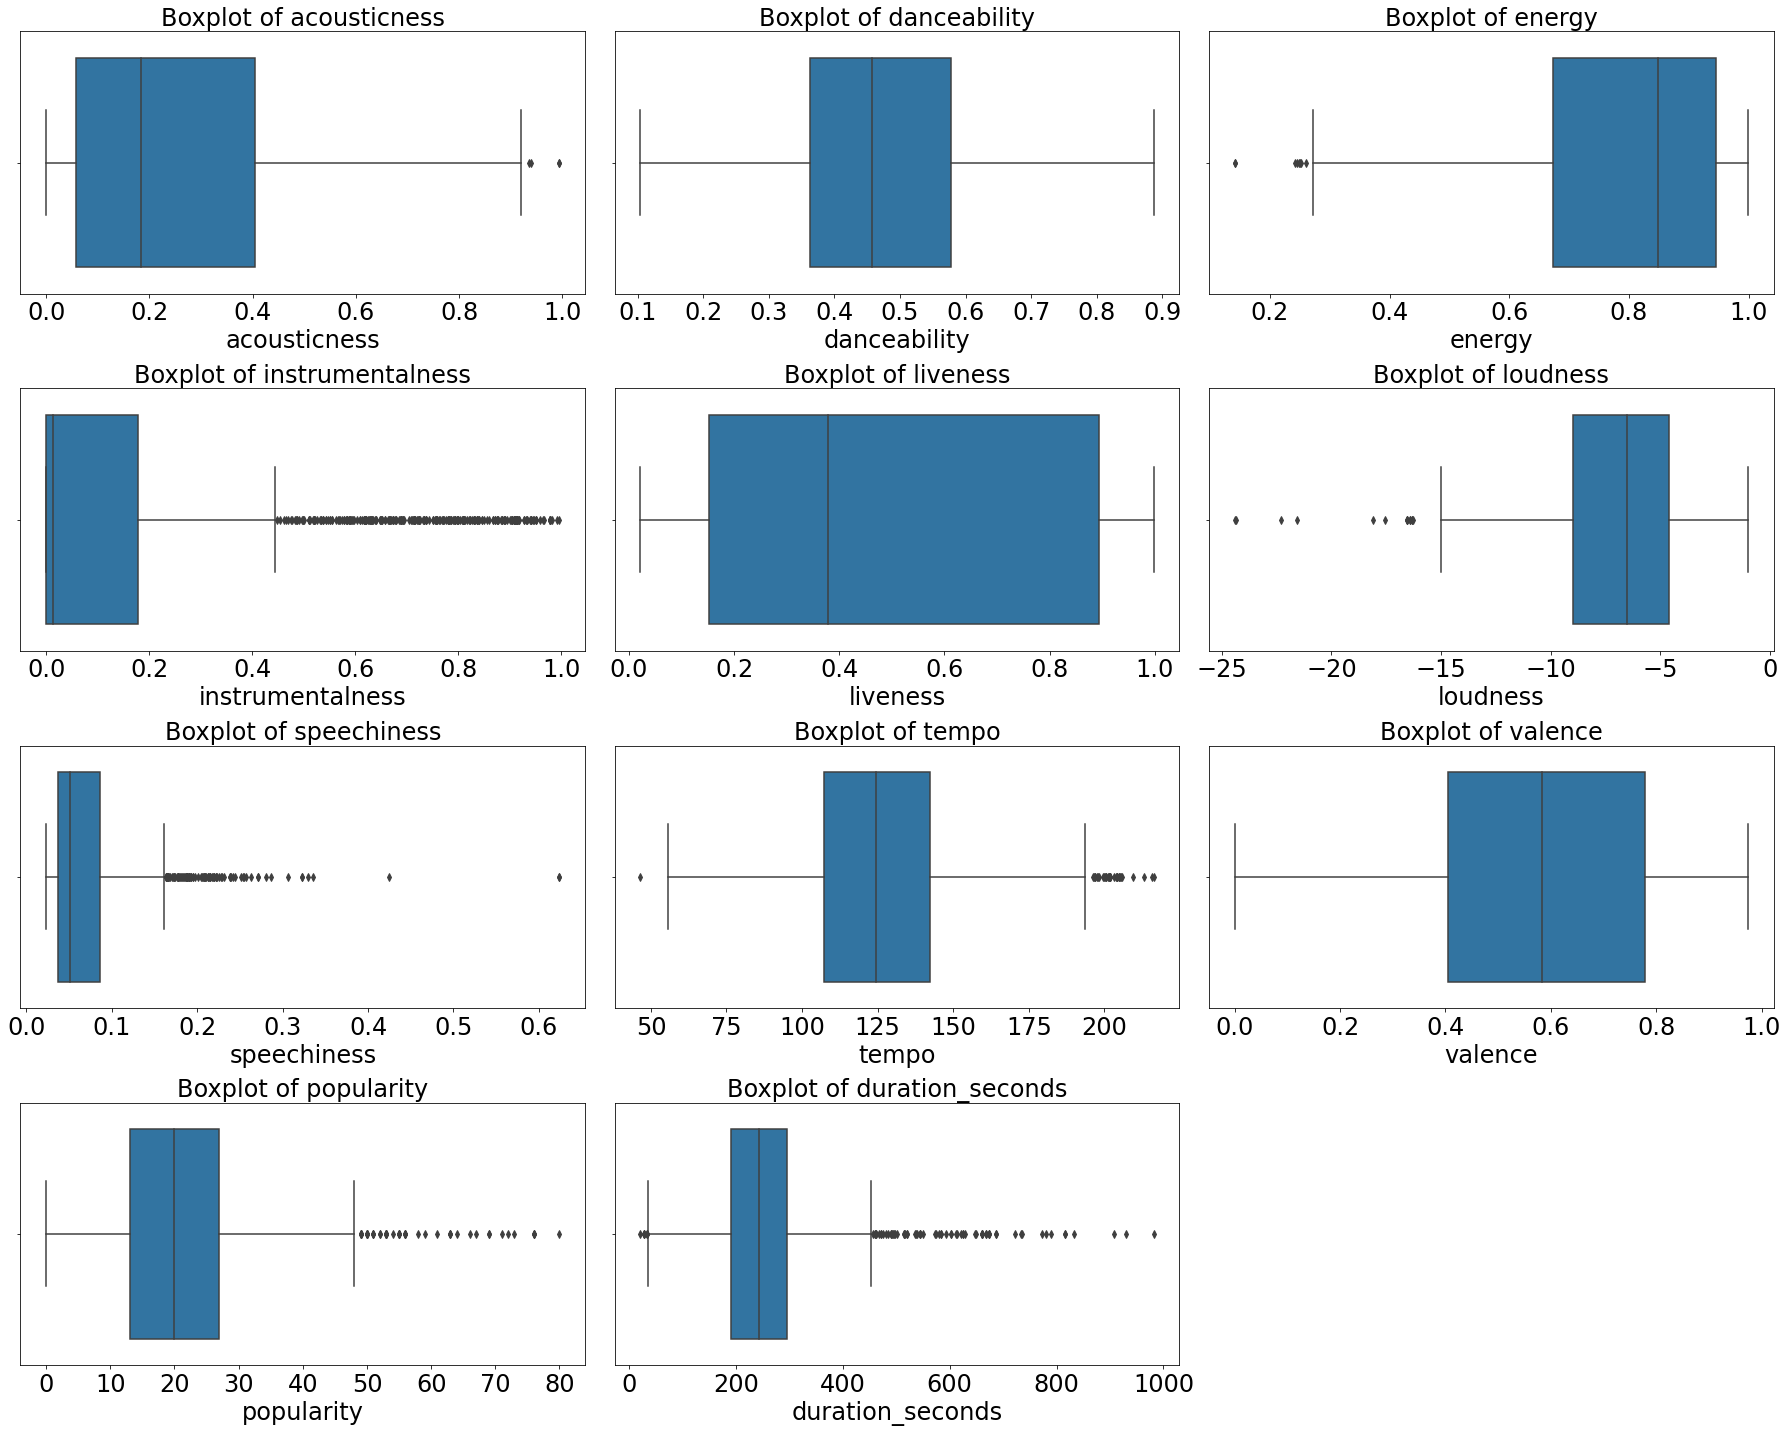

In [10]:
# List of columns for which we want to visualize outliers
columns_to_visualize = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence',
    'popularity', 'duration_seconds'
]

# Set up the matplotlib figure for plotting
plt.figure(figsize=(25, 20))

# Create a boxplot for each of the selected columns
for i, col in enumerate(columns_to_visualize, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=stones_data[col])
    plt.title(f'Boxplot of {col}', fontsize=24)
    plt.xlabel(col, fontsize=24)
    plt.xticks(fontsize=24)

plt.tight_layout()
plt.show()

The following code lists the number of outliers in every column of "columns_to_visualize"

In [11]:
# Function to count outliers using IQR
def count_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers.shape[0]  # Return the count of outliers

# Print number of outliers per column
for col in columns_to_visualize:
    num_outliers = count_outliers(stones_data, col)
    print(f"{col}: {num_outliers} outliers")

acousticness: 4 outliers
danceability: 0 outliers
energy: 8 outliers
instrumentalness: 272 outliers
liveness: 0 outliers
loudness: 14 outliers
speechiness: 92 outliers
tempo: 34 outliers
valence: 0 outliers
popularity: 48 outliers
duration_seconds: 76 outliers


## 2. Refining the Data

Convert release_date to a datetime format for temporal analysis.

In [14]:
# Convert 'release_date' to datetime
stones_data['release_date'] = pd.to_datetime(stones_data['release_date'])

# Extract release year
stones_data['release_year'] = stones_data['release_date'].dt.year

# Display updated info
print("\nDataframe info after cleaning and refining:")
print(stones_data.info())



Dataframe info after cleaning and refining:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              1610 non-null   object        
 1   album             1610 non-null   object        
 2   release_date      1610 non-null   datetime64[ns]
 3   track_number      1610 non-null   int64         
 4   id                1610 non-null   object        
 5   uri               1610 non-null   object        
 6   acousticness      1610 non-null   float64       
 7   danceability      1610 non-null   float64       
 8   energy            1610 non-null   float64       
 9   instrumentalness  1610 non-null   float64       
 10  liveness          1610 non-null   float64       
 11  loudness          1610 non-null   float64       
 12  speechiness       1610 non-null   float64       
 13  tempo             1610 non-null  

## **Perform exploratory data analysis and feature engineering**

**a. Utilize suitable visualizations to identify the two albums that should be
recommended to anyone based on the number of popular songs in each
album**

**b. Conduct exploratory data analysis to delve into various features of songs,
aiming to identify patterns**

**c. Examine the relationship between a song's popularity and various factors,
exploring how this correlation has evolved**

**d. Provide insights on the significance of dimensionality reduction
techniques. Share your ideas and elucidate your observations**

a. **Identifying Top Albums by Popular Songs**
- Group the data by album and calculate the number of songs with high popularity (e.g., popularity > 70).

- Visualize using bar plots to highlight albums with the most popular songs.

b. **Exploring Song Features**
- Use histograms, box plots, and scatter plots to analyze distributions and relationships among features like danceability, energy, and valence.

- Identify patterns such as whether energetic songs tend to have higher popularity.

c. **Correlation Between Popularity and Features**
- Compute correlation coefficients between popularity and other numerical features.

- Use scatter plots to visualize relationships (e.g., between popularity and danceability).

- Analyze trends over time by grouping data by release year.

d. **Dimensionality Reduction Insights**

- Discuss techniques like PCA (Principal Component Analysis) to reduce feature dimensionality while retaining variance.

- Highlight how dimensionality reduction can simplify clustering tasks by reducing noise and redundancy in data.

  

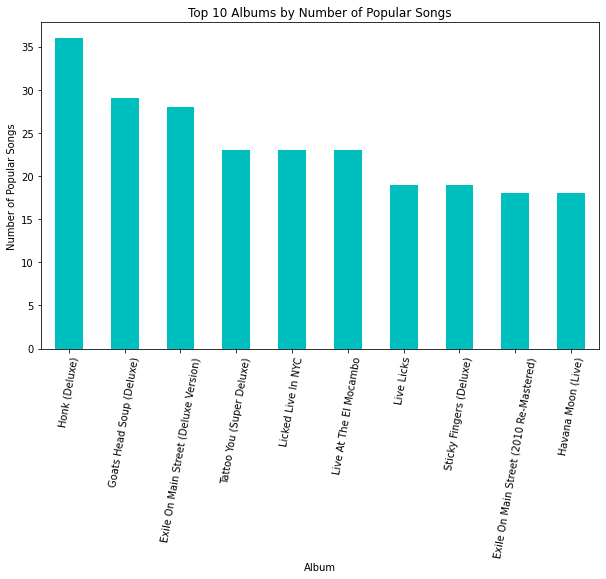

Based on the number of popular songs in each album, we can recommend the top 2 albums:


album
Honk (Deluxe)               36
Goats Head Soup (Deluxe)    29
Name: name, dtype: int64

In [27]:
# Define a popularity threshold, say songs with a popularity score of 50 or higher are considered popular
popularity_threshold = stones_data['popularity'].median()

# Filter the dataset for popular songs
popular_songs = stones_data[stones_data['popularity'] >= popularity_threshold]

# Group the popular songs by album and count the number of popular songs in each album
album_popularity = popular_songs.groupby('album')['name'].count().sort_values(ascending=False)

# Visualize the top albums with the most popular songs
plt.figure(figsize=(10, 6))
album_popularity.head(10).plot(kind='bar', color='c')
plt.title('Top 10 Albums by Number of Popular Songs')
plt.xlabel('Album')
plt.ylabel('Number of Popular Songs')
plt.xticks(rotation=80)
plt.show()

# Display the top 2 albums with the most popular songs
print('Based on the number of popular songs in each album, we can recommend the top 2 albums:')
album_popularity.head(2)

We uses median as the popularity threshold because in this way we can focus on the top 50% of the songs in the dataset. To identify the two albums that should be recommended based on the number of popular songs, we used groupby for the album column and counted the number of songs with high popularity.

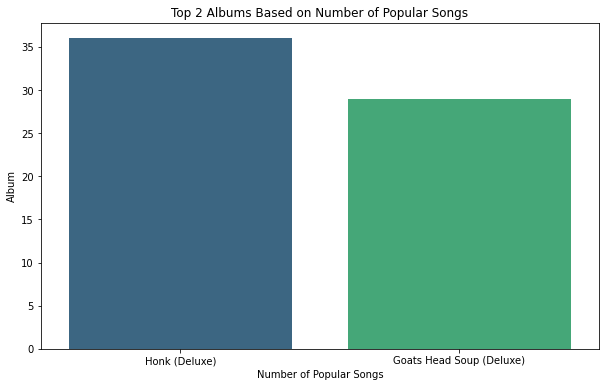

In [28]:
# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=top_albums.index, y=top_albums.values, palette='viridis')
plt.title('Top 2 Albums Based on Number of Popular Songs')
plt.xlabel('Number of Popular Songs')
plt.ylabel('Album')
plt.show()

We can visualize the distribution of the numerical audio features using histograms and KDE plots to better understand their spread.

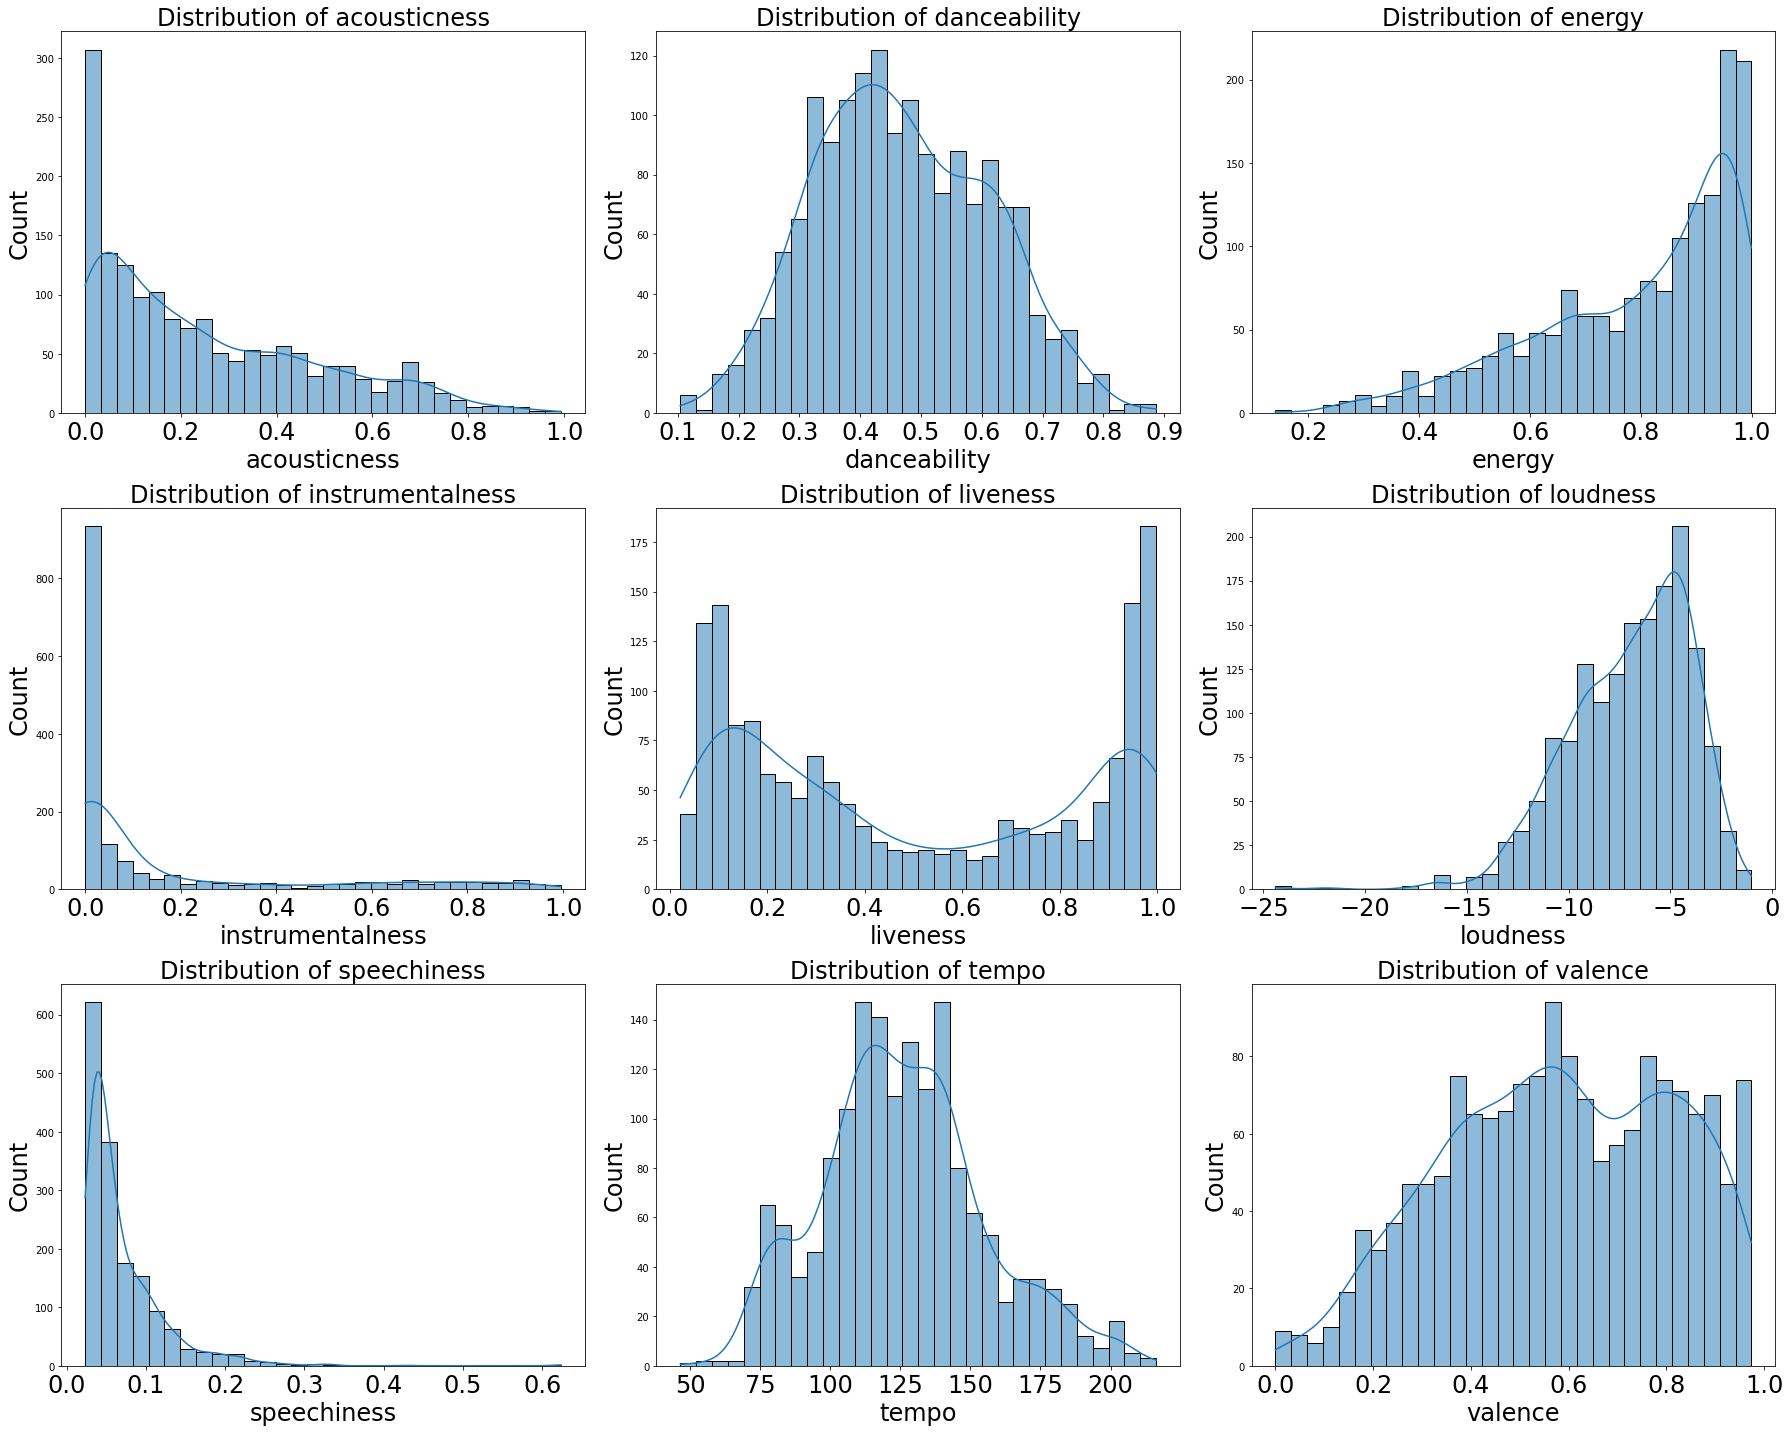

In [47]:
# List of audio feature columns to visualize
audio_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

# Set up the matplotlib figure for plotting
plt.figure(figsize=(25, 20))

# Plot the distribution of each feature
for i, feature in enumerate(audio_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(stones_data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}', fontsize=24)
    plt.xlabel(feature, fontsize=24)  # Corrected to use 'feature' instead of 'col'
    plt.xticks(fontsize=24)
    plt.ylabel('Count', fontsize=24)

plt.tight_layout()
plt.savefig('distribution_plots.png')  # Save the figure as a PNG file
plt.show()

**Key Observations**

* **Danceability, Tempo and Valence:** These features show a roughly normal distribution, suggesting that most songs fall within a specific range, with fewer outliers.
* **Acousticness and Speechiness:** These features show a right-skewed distribution, indicating that a majority of songs have lower values for these features, with a smaller number of songs having higher values.
* **Energy:** The distribution shows leftward skew, suggesting that most songs  have high energy levels.
* **Loudness:** This distribution is close to normal, peaking around -5 dBFS. Most tracks fall within the common loudness range for modern music.
* **Instrumentalness:** The distribution is heavily skewed towards 0, indicating that most tracks have little to no instrumental content, meaning they likely contain vocals.
* **Liveness:** This is a bimodal distribution, with peaks near 0.2 and 1.0. A high value indicates a live performance, so there are two distinct groups: live and studio tracks.

We can use a heatmap to visualize the correlations between different features. This will help us identify any strong positive or negative correlations.

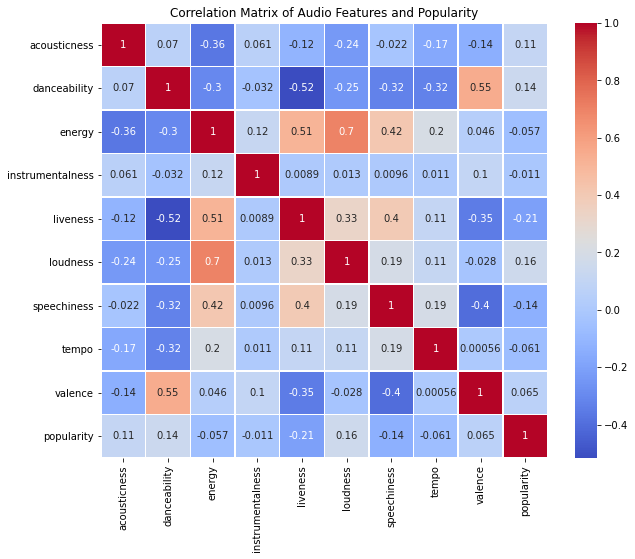

In [24]:
# Compute the correlation matrix
correlation_matrix = stones_data[audio_features + ['popularity']].corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Audio Features and Popularity')
plt.savefig('heatmap_features.png')
plt.show()


## Analyzing the Correlation Heatmap

**Some key Observations:**

1. **Danceability vs. Popularity**:
   - Positive correlation (**0.14**): Songs with higher danceability tend to be more popular, though the correlation is not very strong.

2. **Energy vs. Popularity**:
   - Weak negative correlation (**-0.057**): Energy levels don’t strongly influence popularity. Songs with higher energy do not necessarily gain more popularity.

3. **Valence vs. Popularity**:
   - Weak positive correlation (**0.065**): Songs with a positive, happy tone (high valence) are slightly more popular, but the correlation is small.

4. **Acousticness vs. Popularity**:
   - Slight positive correlation (**0.11**): Acoustic songs may tend to have a slightly higher popularity, though the correlation is weak.

5. **Loudness vs. Popularity**:
   - Moderate positive correlation (**0.16**): Louder tracks are more likely to be popular, which could reflect the modern tendency toward louder production in commercial music.

6. **Instrumentalness vs. Popularity**:
   - Weak negative correlation (**-0.011**): Instrumental songs seem to be slightly less popular, although the relationship is nearly negligible.

7. **Speechiness vs. Popularity**:
   - Slight negative correlation (**-0.14**): Songs with higher speech content (like spoken word or rap) tend to have slightly lower popularity.

8. **Tempo vs. Popularity**:
   - Weak negative correlation (**-0.061**): Tempo doesn’t have a strong impact on popularity, with a minor negative correlation.

9. **Liveness vs. Popularity**:
   - Negative correlation (**-0.21**): Songs that sound more “live” (i.e., recorded with an audience or in a live setting) tend to be less popular.

### Correlations between Features:

- **Danceability and Valence**: Strong positive correlation (**0.55**): Songs that are more danceable tend to have a higher valence, meaning they are happier or more positive.
- **Energy and Loudness**: Strong positive correlation (**0.7**): Louder songs generally have more energy, which is intuitive since both are measures of intensity.
- **Danceability and Liveness**: Negative correlation (**-0.52**): More danceable tracks tend to have lower liveness, suggesting that studio-recorded songs are more danceable than live performances.
- **Liveness and Valence**: Negative correlation (**-0.35**): Songs that are live are generally perceived as less happy or positive.


We can explore the relationship between each feature and the popularity score to see which attributes tend to be associated with more popular songs.

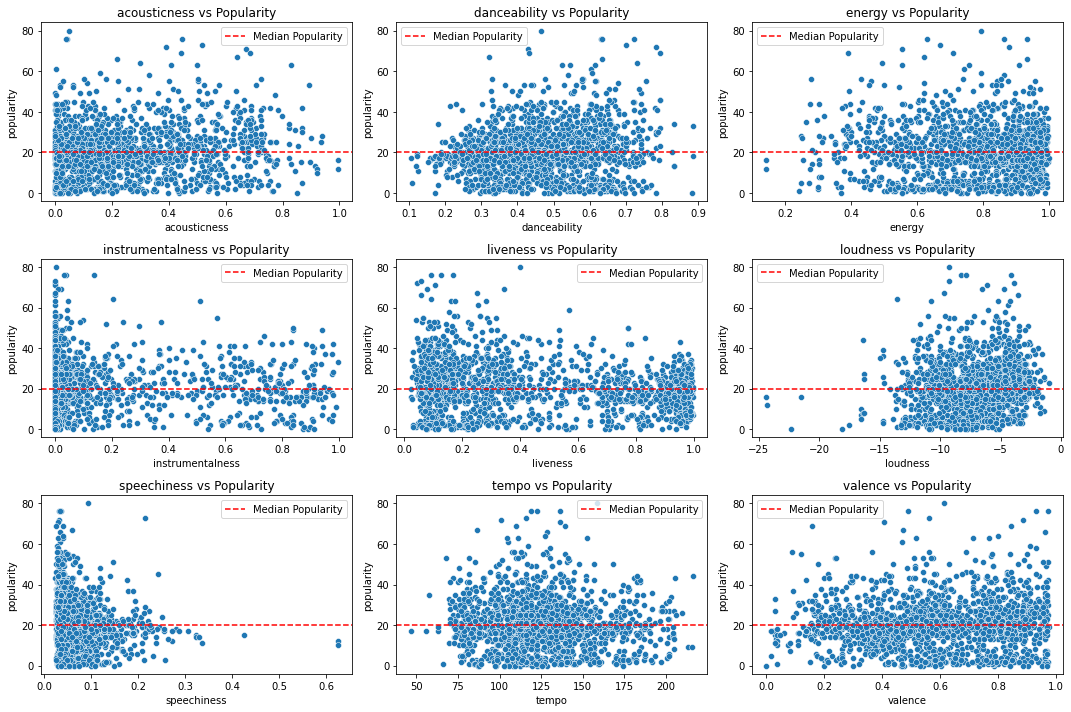

In [21]:
popularity_threshold = stones_data['popularity'].median()
# Plot the relationship between each audio feature and popularity
plt.figure(figsize=(15, 10))
for i, feature in enumerate(audio_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=stones_data[feature], y=stones_data['popularity'])
    plt.axhline(y=popularity_threshold, color='r', linestyle='--', label='Median Popularity')
    plt.title(f'{feature} vs Popularity')
    plt.legend()
plt.tight_layout()
plt.show()

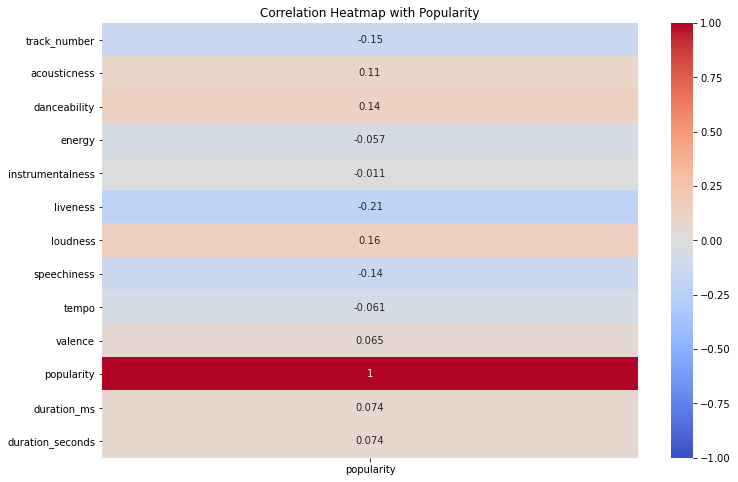

In [22]:
# Correlation heatmap
correlation = stones_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation[['popularity']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap with Popularity')
plt.show()

We see from the correlation heatmap that none of the values is strong enough to imply a significant relationship in most practical scenarios.



Dimensionality reduction techniques like PCA are powerful for simplifying and interpreting high-dimensional data. In this case, PCA allowed us to project the Rolling Stones songs into a 2D space, enabling easier visualization of patterns and clusters.  

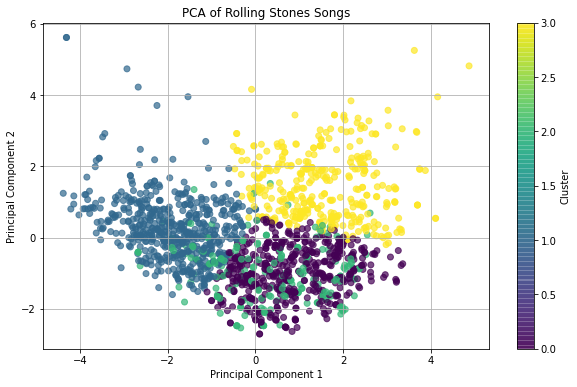

In [71]:
# Select relevant features for PCA
features = ['acousticness', 'danceability', 'energy', 
            'instrumentalness', 'liveness', 'loudness', 
            'speechiness', 'tempo', 'valence']
X = stones_data[features]

# Standardize the data (important for PCA)
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = stones_data['cluster']  # Assuming you have cluster assignments

# Visualize the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap='viridis', alpha=0.7)
plt.title('PCA of Rolling Stones Songs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.savefig('pca.png')
plt.show()

The PCA plot highlights at least three distinct clusters of songs. These clusters suggest that the songs have natural groupings based on their audio features. Cluster 0 and Cluster 1 are close in proximity, suggesting they may share more common features, while Cluster 2 is more spread out. Songs that are close to each other in the PCA plot are more similar in terms of their audio features, while those that are farther apart are more different. The two principal components used for the PCA explain the maximum variance in the dataset, meaning they represent the most significant dimensions. Even though we reduced the data to two dimensions, the plot shows that these components still carry most of the important information needed to differentiate between songs.

In [70]:
# Explained variance ratio to understand how much information is retained
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.32446344 0.17938047]


PC1 (Principal Component 1): 32.45% of the total variance in the dataset is explained by the first principal component.
PC2 (Principal Component 2): 17.94% of the total variance is explained by the second principal component.

Together, PC1 and PC2 explain approximately 50.39% of the total variance in the data. This means that half of the important patterns or relationships in the data are captured by these two principal components. PC1 captures a significantly larger portion of the variance (32.45%) compared to PC2 (17.94%). This suggests that the first principal component is more informative.

## **4. Perform cluster analysis**

**a. Identify the right number of clusters**

**b. Use appropriate clustering algorithms**

**c. Define each cluster based on the features**

In order to identify the right number of clusters, we use the Elbow method. The "elbow" point where the curve starts to flatten indicates the optimal number of clusters.

In [63]:
# Drop unnecessary columns
# Select relevant features for clustering
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
            'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
X = stones_data[features]
display(X)
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.0824,0.463,0.993,0.996000,0.9320,-12.913,0.1100,118.001,0.0302
1,0.4370,0.326,0.965,0.233000,0.9610,-4.803,0.0759,131.455,0.3180
2,0.4160,0.386,0.969,0.400000,0.9560,-4.936,0.1150,130.066,0.3130
3,0.5670,0.369,0.985,0.000107,0.8950,-5.535,0.1930,132.994,0.1470
4,0.4000,0.303,0.969,0.055900,0.9660,-5.098,0.0930,130.533,0.2060
...,...,...,...,...,...,...,...,...,...
1605,0.1570,0.466,0.932,0.006170,0.3240,-9.214,0.0429,177.340,0.9670
1606,0.0576,0.509,0.706,0.000002,0.5160,-9.427,0.0843,122.015,0.4460
1607,0.3710,0.790,0.774,0.000000,0.0669,-7.961,0.0720,97.035,0.8350
1608,0.2170,0.700,0.546,0.000070,0.1660,-9.567,0.0622,102.634,0.5320


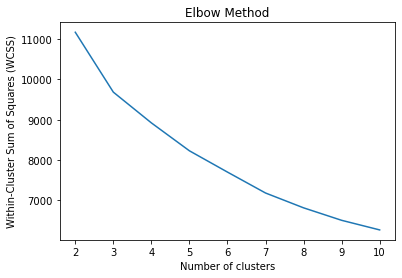

In [64]:
# Elbow method to find the optimal number of clusters
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

The elbow method suggests that the optimal number of clusters is 4.

Let's use K-Means clustering in this case with 4 clusters.

In [65]:
# Apply K-Means clustering with 4 clusters
n_clusters = 4  # Determined from the elbow plot
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred = kmeans.fit_predict(X)
stones_data['cluster'] = y_pred

In [66]:
# Get cluster centroids
centroids = kmeans.cluster_centers_

# Analyze cluster centroids
for i in range(n_clusters):
    print(f"Cluster {i}:")
    print(f"Centroid: {centroids[i]}")
    print(f"Percentage of songs: {(y_pred == i).mean() * 100:.2f}%")
    print("---")

Cluster 0:
Centroid: [-0.36952365  0.66173841  0.06696196 -0.3954455  -0.56520178  0.04574832
 -0.39776173 -0.11908225  0.79905125]
Percentage of songs: 30.62%
---
Cluster 1:
Centroid: [-0.26706534 -0.78492068  0.73914854 -0.1838543   0.96753055  0.54737236
  0.75697561  0.41226637 -0.60695431]
Percentage of songs: 34.10%
---
Cluster 2:
Centroid: [-0.03680563  0.28517506  0.22002462  2.08509215 -0.22066875  0.08862848
 -0.3012729  -0.00681016  0.66836086]
Percentage of songs: 12.30%
---
Cluster 3:
Centroid: [ 0.91527336  0.12743554 -1.31115107 -0.31567042 -0.56442113 -0.9258187
 -0.43216174 -0.45119596 -0.52893453]
Percentage of songs: 22.98%
---


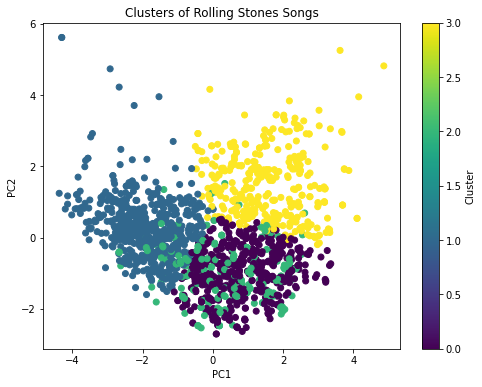

In [67]:
# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters of Rolling Stones Songs')
plt.colorbar(label='Cluster')
plt.show()

In [68]:
# Calculate mean feature values for each cluster
cluster_means = stones_data.groupby('cluster')[features].mean()
display(cluster_means)

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
cluster,,,,,,,,,
0,0.164389,0.562323,0.804292,0.055185,0.293337,-6.817465,0.048978,122.549247,0.766692
1,0.189764,0.357612,0.925273,0.113396,0.829389,-5.333290,0.108584,138.130271,0.441849
2,0.242108,0.509278,0.831919,0.739995,0.414718,-6.706343,0.053962,125.883010,0.736678
3,0.459738,0.487765,0.558043,0.076577,0.296272,-9.749886,0.047221,113.018754,0.461811


We used K-Means clustering and defined each cluster based on the mean values of relevant features on the Rolling Stones Spotify dataset to identify distinct groups of songs based on their audio features.

# Cluster Definitions and Insights

### Cluster 0
- **Characteristics**: 
  - High energy
  - High tempo
  - High loudness
  - Moderate danceability
  - Low acousticness
- **Insight**: This cluster likely represents high-energy rock tracks that are suitable for dancing or live performances.

### Cluster 1
- **Characteristics**:
  - High liveness
  - High energy
  - Low danceability
- **Insight**: This cluster has the highest energy level among all clusters and high liveness which suggests that the songs might be live recordings and very energetic. The lower danceability indicates that while they are energetic, they may not necessarily be intended for dancing.

### Cluster 2
- **Characteristics**:
  - Moderate energy
  - Relatively high acousticness and instrumentalness
  - Moderate danceability
- **Insight**: This cluster features tracks that might appeal to listeners who enjoy both rhythm and melody. The higher acousticness and instrumentalness compared to other clusters indicates the songs are of soft rock genre.

### Cluster 3
- **Characteristics**:
  - Moderate danceability
  - High acousticness
  - Low loudness
  - Low energy
- **Insight**: This cluster is characterized by the highest acousticness, lower energy and loudness and moderate danceability. This suggests that the songs are more mellow, softer tracks that are not designed for dancing.